In [1]:
from embeddings.embedding_utils import get_queries
import pickle

data_queries = get_queries()
def get_filename_xmeans(category, query):
    save_path = f"../cluster_results/openai_api__get_embedding/xmeans_clustering/"
    query_key = (category[:5] + "_" + query[:10]).replace(" ", "_")
    return save_path + query_key + ".pkl"

def load_clustering(category, query):
    filename = get_filename_xmeans(category, query)
    with open(filename, "rb") as f:
        data_dict = pickle.load(f)
    return data_dict["embeddings"], data_dict["clusters"], data_dict["numerical_labels_true"], data_dict["categorizer"]

In [2]:
def get_filename_original(category, query):
    save_path = "../query_results/"
    query_key = (category[:5] + "_" + query[:10]).replace(" ", "_")
    return save_path + query_key + ".pkl"
def load_original(category, query):
    filename = get_filename_original(category, query)
    with open(filename, "rb") as f:
        data_dict = pickle.load(f)
    return data_dict["data"], data_dict["numerical_labels"], data_dict["categorizer"]

In [3]:
category = "Earth and Environmental Science"
query = data_queries[category][0]

In [4]:
embedding, clusters, numerical_labels_true, categorizer = load_clustering(category, query)
original_documents, numerical_labels, categorizer_original = load_original(category, query)

In [5]:
import umap

umap_2d_embedding = umap.UMAP(n_components=2).fit_transform(embedding)


C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
grouped_documents = {}
for document, cluster, numerical_label_true in zip(original_documents, clusters, numerical_labels_true):
    grouped_documents[cluster] = grouped_documents.get(cluster, []) + [(document, numerical_label_true)]

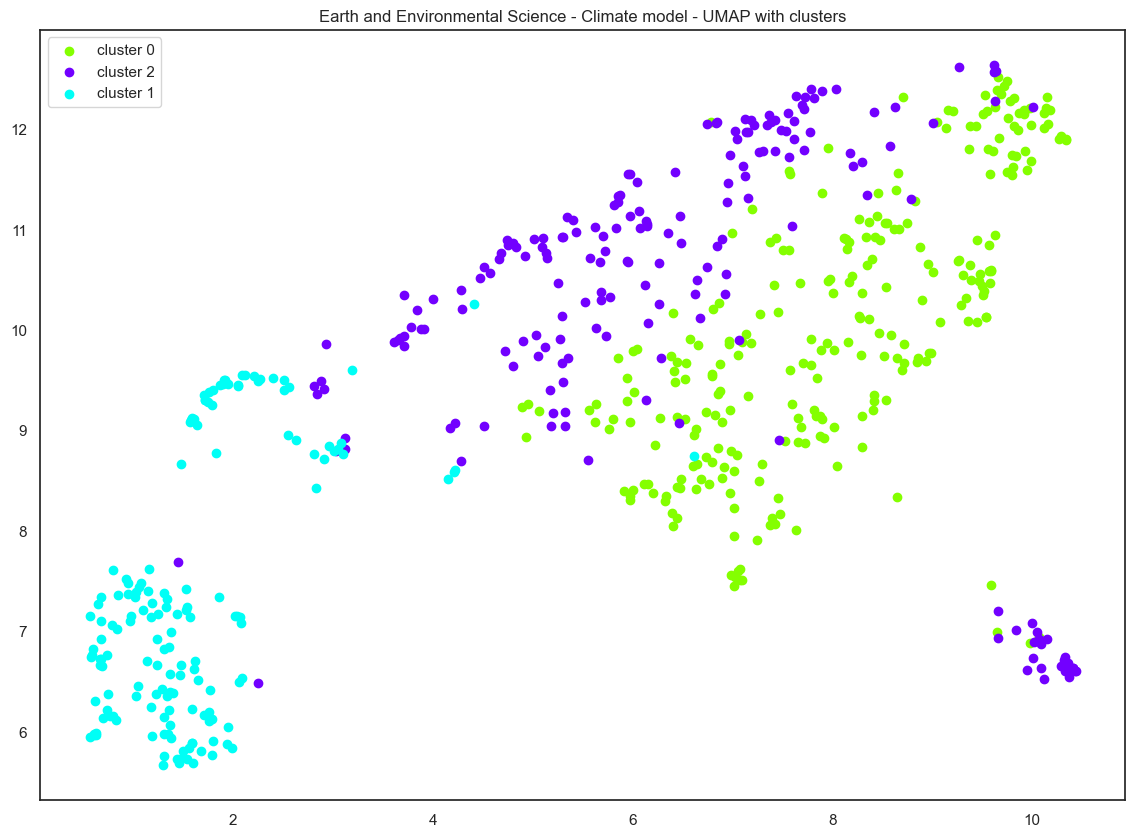

In [7]:
# plot umap with clusters
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.figure()
colors = sns.color_palette("hsv", len(grouped_documents))
for cluster, documents in grouped_documents.items():
    cluster_embedding = umap_2d_embedding[np.array(clusters) == cluster]
    plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1], c=[colors[cluster]], label=f"cluster {cluster}")
plt.legend()
plt.title(f"{category} - {query} - UMAP with clusters")
plt.show()

In [8]:
# general label distribution
import pandas as pd
from collections import Counter
from embeddings.embedding_utils import to_full_name
label_counts = Counter([lab for label_list in numerical_labels_true for lab in label_list])
label_counts = pd.DataFrame(label_counts.items(), columns=["label", "count"])
label_counts["label_string"] = label_counts["label"].apply(lambda x: to_full_name(categorizer.get_label_str(x)))
label_counts = label_counts.sort_values(by="count", ascending=False)
print(label_counts.head(20))

    label  count                                  label_string
4      37    271               Atmospheric and Oceanic Physics
18     36    173              Earth and Planetary Astrophysics
5      49     68                                    Geophysics
15     74     56                                  Applications
36     55     42                              Machine Learning
11     38     34                                Fluid Dynamics
25     39     32     Data Analysis, Statistics and Probability
29    113     29                                   Methodology
12     14     29                         Computational Physics
7      94     26  Distributed, Parallel, and Cluster Computing
13      5     25                         Statistical Mechanics
37     96     24                              Machine Learning
16     25     23                              Chaotic Dynamics
17     67     19                Solar and Stellar Astrophysics
27     82     18                             Dynamical 

In [9]:
head = label_counts.head(15)
for lab_str, count in zip(head["label_string"], head["count"]):
    print(lab_str, count)

Atmospheric and Oceanic Physics 271
Earth and Planetary Astrophysics 173
Geophysics 68
Applications 56
Machine Learning 42
Fluid Dynamics 34
Data Analysis, Statistics and Probability 32
Methodology 29
Computational Physics 29
Distributed, Parallel, and Cluster Computing 26
Statistical Mechanics 25
Machine Learning 24
Chaotic Dynamics 23
Solar and Stellar Astrophysics 19
Dynamical Systems 18


In [10]:
# latex code displaying the top 15 Labels and their count in a table
sep = " \\\\\n"
table= f"""
{sep.join([f'{lab_str} & {count}' for lab_str, count in zip(label_counts.head(15)["label_string"],label_counts.head(15)["count"])])}
"""
table += sep + f"""Others & {sum(label_counts["count"][15:])}"""
print(table)


Atmospheric and Oceanic Physics & 271 \\
Earth and Planetary Astrophysics & 173 \\
Geophysics & 68 \\
Applications & 56 \\
Machine Learning & 42 \\
Fluid Dynamics & 34 \\
Data Analysis, Statistics and Probability & 32 \\
Methodology & 29 \\
Computational Physics & 29 \\
Distributed, Parallel, and Cluster Computing & 26 \\
Statistical Mechanics & 25 \\
Machine Learning & 24 \\
Chaotic Dynamics & 23 \\
Solar and Stellar Astrophysics & 19 \\
Dynamical Systems & 18
 \\
Others & 193


FileNotFoundError: [Errno 2] No such file or directory: '../cluster_results/xmeans_clustering/Earth and Environmental Science_Climate model_top_6_labels.png'

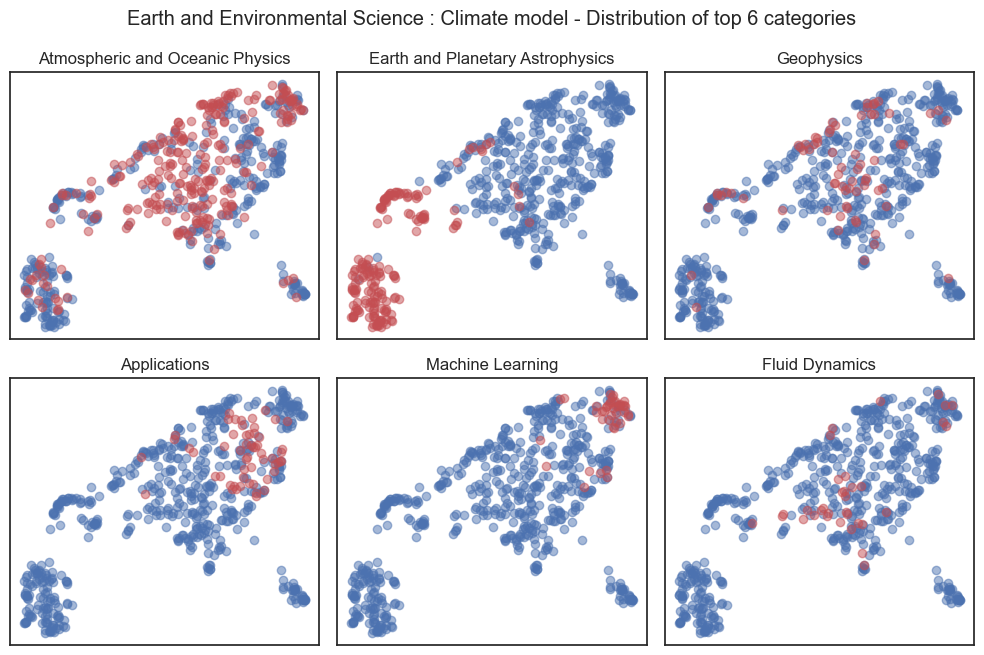

In [11]:
# plot the top 6 numerical labels in a 2x3 grid, each plot highlithing a different label
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
fig, axs = plt.subplots(2, 3, figsize=(10, 6.666))
for i, (highlighted_numerical_label, label_name) in enumerate(zip(label_counts["label"].values[:6], label_counts["label_string"].values[:6])):
    mask = np.array([highlighted_numerical_label in label_list for label_list in numerical_labels_true])
    ax = axs[i // 3, i % 3]
    ax.scatter(umap_2d_embedding[~mask][:,0], umap_2d_embedding[~mask][:,1], c="b", alpha=0.5)
    ax.scatter(umap_2d_embedding[mask][:,0], umap_2d_embedding[mask][:,1], c="r", alpha=0.5)
    ax.set_title(f"{label_name}")
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle(f"{category} : {query} - Distribution of top 6 categories")
plt.tight_layout()
plt.savefig(f"../cluster_results/xmeans_clustering/{category}_{query}_top_6_labels.png", dpi=300)
plt.show()

In [25]:
# get tf-idf embedding
query_key = (category[:5] + "_" + query[:10]).replace(" ", "_")
folder_embedding="../embedding_results/openai_api__get_embedding"
filename = f"{folder_embedding}/{query_key}.pkl"
with open(filename, "rb") as f:
    data_tf_idf_dict = pickle.load(f)
data_tf_idf = data_tf_idf_dict["embeddings"]

In [26]:

umap_2d_embedding = umap.UMAP(n_components=2, min_dist=1).fit_transform(data_tf_idf)

C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


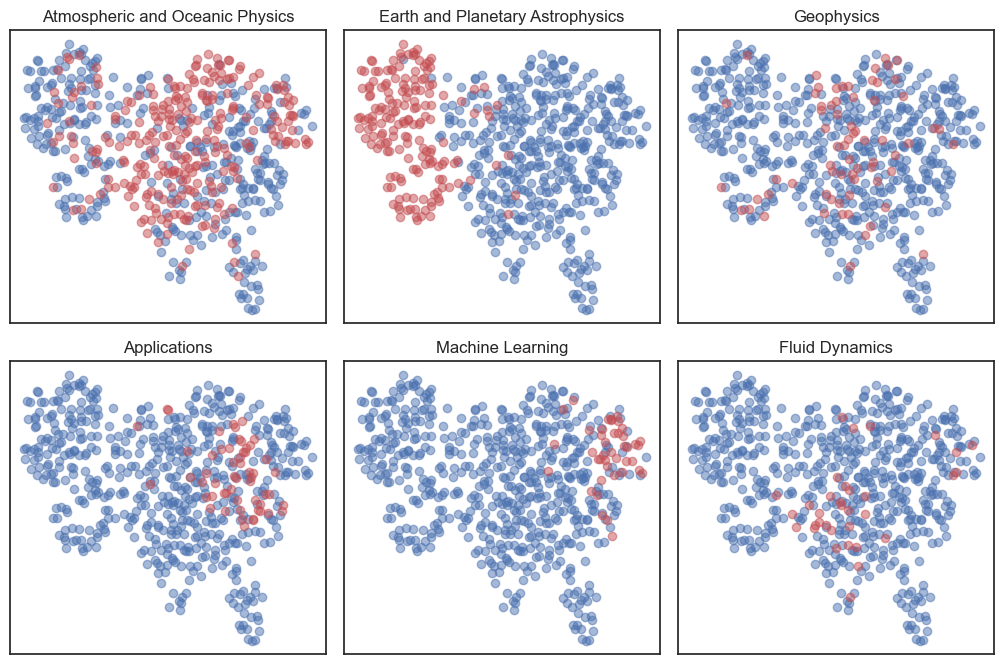

In [27]:

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
y,x = 2,3
fig, axs = plt.subplots(y, x, figsize=(3.4*x, 3.4*y))
num_of_plots = min(x*y, len(label_counts))
for i, (highlighted_numerical_label, label_name) in enumerate(zip(label_counts["label"].values[:num_of_plots], label_counts["label_string"].values[:num_of_plots])):
    mask = np.array([highlighted_numerical_label in label_list for label_list in numerical_labels_true])
    ax = axs[i // x, i % x]
    ax.scatter(umap_2d_embedding[~mask][:,0], umap_2d_embedding[~mask][:,1], c="b", alpha=0.5)
    ax.scatter(umap_2d_embedding[mask][:,0], umap_2d_embedding[mask][:,1], c="r", alpha=0.5)
    ax.set_title(f"{label_name}")
    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{folder_embedding}/{category}_{query}_top_{num_of_plots}_labels.png", dpi=300)
plt.show()